In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [2]:
image_size = (128, 128)
batch_size = 32

In [5]:
vgg_model = tf.keras.applications.VGG19(include_top=False,
                                       weights=None,
                                       input_shape=(128,128,3))

In [3]:
vgg_model.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 32, 32, 128)       0     

In [6]:
len(vgg_model.layers)

22

In [5]:
fine_tune_layer = 7

In [7]:
vgg_model.trainable = True

In [7]:
for model_layer in vgg_model.layers[:len(vgg_model.layers) - fine_tune_layer]:
    print(f"FREEZING LAYER: {model_layer}")
    model_layer.trainable = False

FREEZING LAYER: <keras.src.engine.input_layer.InputLayer object at 0x000001F0914F8FD0>
FREEZING LAYER: <keras.src.layers.convolutional.conv2d.Conv2D object at 0x000001F09EB5C410>
FREEZING LAYER: <keras.src.layers.convolutional.conv2d.Conv2D object at 0x000001F09EC36CD0>
FREEZING LAYER: <keras.src.layers.pooling.max_pooling2d.MaxPooling2D object at 0x000001F09ED0BB10>
FREEZING LAYER: <keras.src.layers.convolutional.conv2d.Conv2D object at 0x000001F09E992B10>
FREEZING LAYER: <keras.src.layers.convolutional.conv2d.Conv2D object at 0x000001F09EB5F610>
FREEZING LAYER: <keras.src.layers.pooling.max_pooling2d.MaxPooling2D object at 0x000001F09ED27F50>
FREEZING LAYER: <keras.src.layers.convolutional.conv2d.Conv2D object at 0x000001F09ED277D0>
FREEZING LAYER: <keras.src.layers.convolutional.conv2d.Conv2D object at 0x000001F09EB55410>
FREEZING LAYER: <keras.src.layers.convolutional.conv2d.Conv2D object at 0x000001F09EC07F10>
FREEZING LAYER: <keras.src.layers.convolutional.conv2d.Conv2D object at

In [8]:
vgg_model.summary(show_trainable=True)

Model: "vgg19"
____________________________________________________________________________
 Layer (type)                Output Shape              Param #   Trainable  
 input_2 (InputLayer)        [(None, 128, 128, 3)]     0         Y          
                                                                            
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      Y          
                                                                            
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     Y          
                                                                            
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         Y          
                                                                            
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     Y          
                                                                            
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584

In [9]:
train_data = tf.keras.utils.image_dataset_from_directory('Training/', 
                                                        image_size=image_size,
                                                        validation_split=0.2,
                                                        subset='training',
                                                        shuffle=True,
                                                        seed=10)

Found 5712 files belonging to 4 classes.
Using 4570 files for training.


In [10]:
val_data = tf.keras.utils.image_dataset_from_directory('Training/',
                                                      image_size=image_size,
                                                      validation_split=0.2,
                                                      subset='validation',
                                                      shuffle=True,
                                                      seed=10)

Found 5712 files belonging to 4 classes.
Using 1142 files for validation.


In [11]:
test_data = tf.keras.utils.image_dataset_from_directory('Testing/',
                                                       image_size=image_size,
                                                       batch_size=32,
                                                       shuffle=False,
                                                       seed=10)

Found 1311 files belonging to 4 classes.


In [12]:
rescale_fn = tf.keras.layers.Rescaling(scale=1./255)

train_data = train_data.map(lambda x, y: (rescale_fn(x), y))
val_data = val_data.map(lambda x, y: (rescale_fn(x), y))
test_data = test_data.map(lambda x, y: (rescale_fn(x), y))

In [13]:
cnn = tf.keras.Sequential([
    vgg_model,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(4, activation='softmax')
])

In [15]:
cnn.compile(optimizer = 'adam',   
            loss=tf.keras.losses.SparseCategoricalCrossentropy(), 
            metrics = ['accuracy', 'mse'])

In [16]:
history = cnn.fit(train_data,
       validation_data=val_data,
       epochs=15)

Epoch 1/15


 25/143 [====>.........................] - ETA: 9:29 - loss: 1.3896 - accuracy: 0.2600 - mse: 2.8094

KeyboardInterrupt: 

In [49]:
y_pred = cnn.predict(test_data)

41/41 [==============================] - 56s 1s/step


In [50]:
y_pred = tf.argmax(y_pred, axis=1).numpy()

In [51]:
y_pred

array([0, 0, 0, ..., 3, 3, 3], dtype=int64)

In [53]:
y_true = []
for images, labels in test_data:
    y_true.extend(labels.numpy())
y_true = np.array(y_true)

In [54]:
y_true

array([0, 0, 0, ..., 3, 3, 3])

In [57]:
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, ConfusionMatrixDisplay

In [58]:
accuracy_score(y_true, y_pred)

0.9496567505720824

In [59]:
cm = confusion_matrix(y_true, y_pred)
cm

array([[278,  20,   0,   2],
       [  9, 273,   8,  16],
       [  0,   3, 398,   4],
       [  1,   3,   0, 296]], dtype=int64)

In [77]:
class_names = train_data.class_names

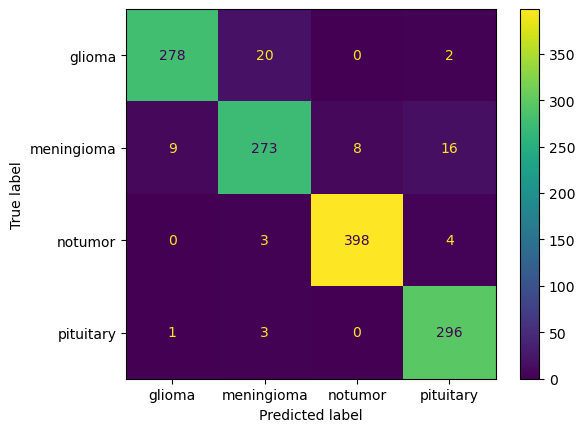

In [80]:
cmd = ConfusionMatrixDisplay(cm, display_labels=class_names)
cmd.plot()
plt.show()

In [83]:
print(classification_report(y_true, y_pred, target_names=class_names))

              precision    recall  f1-score   support

      glioma       0.97      0.93      0.95       300
  meningioma       0.91      0.89      0.90       306
     notumor       0.98      0.98      0.98       405
   pituitary       0.93      0.99      0.96       300

    accuracy                           0.95      1311
   macro avg       0.95      0.95      0.95      1311
weighted avg       0.95      0.95      0.95      1311



In [84]:
cnn.save('saved_models/vgg19_finetune.keras')

In [91]:
cnn.summary(expand_nested=True, show_trainable=True)

Model: "sequential_2"
____________________________________________________________________________
 Layer (type)                Output Shape              Param #   Trainable  
 vgg19 (Functional)          (None, 4, 4, 512)         2002438   Y          
                                                       4                    
|¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯|
| input_2 (InputLayer)       [(None, 128, 128, 3)]     0         N         |
|                                                                          |
| block1_conv1 (Conv2D)      (None, 128, 128, 64)      1792      N         |
|                                                                          |
| block1_conv2 (Conv2D)      (None, 128, 128, 64)      36928     N         |
|                                                                          |
| block1_pool (MaxPooling2D  (None, 64, 64, 64)        0         N         |
| )                                                   